 # 練習問題:金融機関のキャンペーン分析

In [527]:
import unittest
import doctest
import os
path = os.path.dirname(os.path.abspath(__file__))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.tree import plot_tree

# データの可視化設定
plot_on = True

def new_df():
    """データフレームの作成"""
    df = pd.read_csv(path + '/data/Bank.csv', sep=',')
    return df

def plot_df(df):
    def plot_df_hist():
        """データの分布確認"""
        df.hist(figsize=(10, 10))
        plt.show()

    def plot_df_boxplot():
        """データの外れ値確認"""
        df.boxplot(figsize=(10, 10))
        plt.show()

    def plot_df_pairplot():
        """データの可視化"""
        sns.set()
        sns.pairplot(df, hue='y')
        plt.show()

    def exec_all(on=True):
        if on:
            plot_df_hist()
            plot_df_boxplot()
            plot_df_pairplot()

    return exec_all

# x:特徴量 t:正解データ depth:木の深さ
def learn(x, t, depth=3):
    """決定木による学習"""
    x_train, x_test, y_train, y_test = train_test_split(x, t, test_size=0.2, random_state=0)

    model = tree.DecisionTreeClassifier(max_depth=depth, random_state=0, class_weight='balanced')
    model.fit(x_train, y_train)

    score = model.score(X = x_train, y = y_train)
    score2 = model.score(X = x_test, y = y_test)
    return round(score, 3), round(score2, 3), model

def check_learn(x, t, depth=14):
    """学習の確認"""
    for j in range(1, depth + 1): # jは木の深さ（1～14が入る）
    # xは特徴量、tは正解データ
        train_score, test_score, model = learn(x, t, depth=j)
        sentence = '訓練データの正解率{}:'
        sentence2 = 'テストデータの正解率{}'
        total_sentence = '深さ{}:' + sentence + sentence2
        print(total_sentence.format(j, train_score, test_score))

class CategoricalData:
    def __init__(self, df, col) -> None:
        self.df = df
        self.col = col

    def show(self):
        """カテゴリーデータの値の数を確認"""
        return self.df[self.col].value_counts()

    def plot(self):
        """カテゴリーデータの値の数を棒グラフで確認"""
        return self.df[self.col].value_counts().plot(kind='bar')

    def convert(self):
        """カテゴリーデータを数値に変換"""
        from sklearn.preprocessing import LabelEncoder

        encoder = LabelEncoder()
        self.df[self.col] = encoder.fit_transform(self.df[self.col])

    def pivot(self, value):
        """ピボットテーブルによる集計"""
        return self.df.pivot_table(index='y', columns=self.col, values=value, aggfunc='count')

    def dummy(self):
        """ダミー変数化"""
        return pd.get_dummies(self.df, columns=[self.col])

 ## データの内容
 |列名|意味|
 |:--|:--|
 |id|顧客ID|
 |age|年齢|
 |job|職種|
 |education|最終学歴|
 |marital|既婚／未婚／離別など
 |loan|個人ローンの有無|
 |housing|住宅ローンの有無|
 |amount|年間キャンペーン終了時点での、総投資信託購入額|
 |default|債務不履行の有無|
 |previous|キャンペーン前に接触した回数|
 |campaign|現キャンペーン内での接触回数|
 |day|最終接触日|
 |month|最終接触月|
 |duration|接触時のへ平均時間（秒）|
 |y|今回のキャンペーンの結果（1:購入、0:未購入|

 ## 問題背景
 スッキリ銀行は、預貯金や融資のほかに、投資信託商品の販売も行っていますが、購入顧客数や顧客一人あたりの平均購入金額は伸び悩んでいます。

 そこで、昨年度の1年間はテレアポや資料の郵送など、銀行側から顧客に接触を図る各種のキャンペーンを実施しました。初の年間キャンペーンでもあり、さまざまな顧客に手あたり次第接触を試みましたが、次回のキャンペーンでは昨年得られたデータを生かして、もっと効率よく実施したいと考えています。

 さて、スッキリ銀行の課題を解決するためには、行ったキャンペーンが効果的だったか検証する必要があります。また、どうゆう顧客が購入してくれたのか、顧客特性の考察も必要です。

 ## データ分析の方法検討

 ### CSVファイルの読み込み

In [528]:
import pandas as pd
df = pd.read_csv(path + '/data/Bank.csv', sep=',')
df.head()

,id,age,job,marital,education,default,amount,housing,loan,contact,day,month,duration,campaign,previous,y
0,1,39,blue-collar,married,secondary,no,1756.0,yes,no,cellular,3,apr,370.055237,1,0,1
1,2,51,entrepreneur,married,primary,no,1443.0,no,no,cellular,18,feb,233.998933,10,0,1
2,3,36,management,single,tertiary,no,436.0,no,no,cellular,13,apr,NaN,1,2,0
3,4,63,retired,married,secondary,no,474.0,no,no,cellular,25,jan,252.525808,1,0,0
4,5,31,management,single,tertiary,no,354.0,no,no,cellular,30,apr,NaN,1,2,0


 ### データの概要確認

In [529]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27128 entries, 0 to 27127
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         27128 non-null  int64  
 1   age        27128 non-null  int64  
 2   job        27128 non-null  object 
 3   marital    27128 non-null  object 
 4   education  27128 non-null  object 
 5   default    27128 non-null  object 
 6   amount     27128 non-null  float64
 7   housing    27128 non-null  object 
 8   loan       27128 non-null  object 
 9   contact    27128 non-null  object 
 10  day        27128 non-null  int64  
 11  month      27128 non-null  object 
 12  duration   20084 non-null  float64
 13  campaign   27128 non-null  int64  
 14  previous   27128 non-null  int64  
 15  y          27128 non-null  int64  
dtypes: float64(2), int64(6), object(8)
memory usage: 3.3+ MB


 ### データの統計量確認

In [530]:
df.describe()

,id,age,amount,day,duration,campaign,previous,y
count,27128.000000,27128.000000,27128.000000,27128.000000,20084.000000,27128.000000,27128.000000,27128.000000
mean,13564.500000,40.951010,1345.660830,15.806215,318.222068,2.751769,0.579733,0.320075
std,7831.323388,10.608542,2992.015091,8.337904,81.871200,3.126594,2.503653,0.466514
min,1.000000,18.000000,-6847.000000,1.000000,19.038719,1.000000,0.000000,0.000000
25%,6782.750000,33.000000,75.000000,8.000000,260.279269,1.000000,0.000000,0.000000
50%,13564.500000,39.000000,449.000000,16.000000,314.708107,2.000000,0.000000,0.000000
75%,20346.250000,48.000000,1405.250000,21.000000,369.829530,3.000000,0.000000,1.000000
max,27128.000000,95.000000,102127.000000,31.000000,1435.488040,63.000000,275.000000,1.000000


 ### データの特徴量の相関確認

In [531]:
df.corr()

,id,age,amount,day,duration,campaign,previous,y
id,1.000000,-0.005716,-0.000719,0.002974,0.007790,0.016867,-0.005425,0.001353
age,-0.005716,1.000000,0.094546,-0.008518,0.207467,-0.001340,0.002946,0.093856
amount,-0.000719,0.094546,1.000000,0.002127,-0.034113,-0.016176,0.012239,-0.009768
day,0.002974,-0.008518,0.002127,1.000000,-0.024676,0.164880,-0.050009,0.023500
duration,0.007790,0.207467,-0.034113,-0.024676,1.000000,-0.024244,0.137363,0.275922
campaign,0.016867,-0.001340,-0.016176,0.164880,-0.024244,1.000000,-0.031557,0.145963
previous,-0.005425,0.002946,0.012239,-0.050009,0.137363,-0.031557,1.000000,0.022762
y,0.001353,0.093856,-0.009768,0.023500,0.275922,0.145963,0.022762,1.000000


 ### データの特徴量確認

In [532]:
df.columns

Index(['id', 'age', 'job', 'marital', 'education', 'default', 'amount',
       'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign',
       'previous', 'y'],
      dtype='object')

 ### データの数値変数確認

In [533]:
df.select_dtypes(include='number').columns

Index(['id', 'age', 'amount', 'day', 'duration', 'campaign', 'previous', 'y'], dtype='object')

 ### データのカテゴリカル変数確認

In [534]:
df.select_dtypes(include='object').columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month'],
      dtype='object')

 ### 職種カテゴリ

In [535]:
job = CategoricalData(df, 'job')

 ### 職種カテゴリ確認

In [536]:
job.show()

blue-collar      5886
management       5620
technician       4491
admin.           3085
services         2506
retired          1391
self-employed     945
entrepreneur      914
unemployed        790
housemaid         765
student           557
unknown           178
Name: job, dtype: int64

<Axes: >

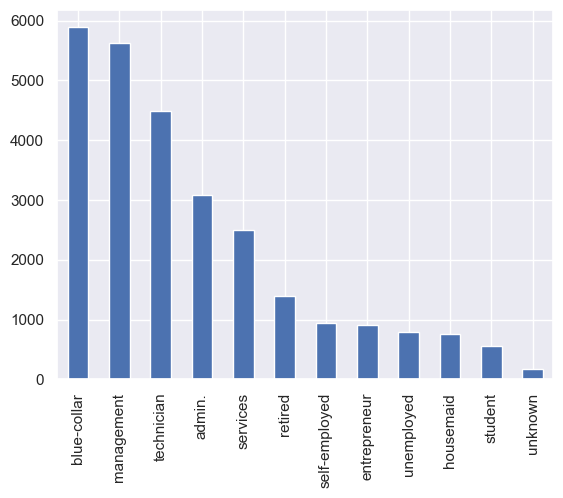

In [537]:
job.plot()

 #### カテゴリーデータを数値に変換

<Axes: >

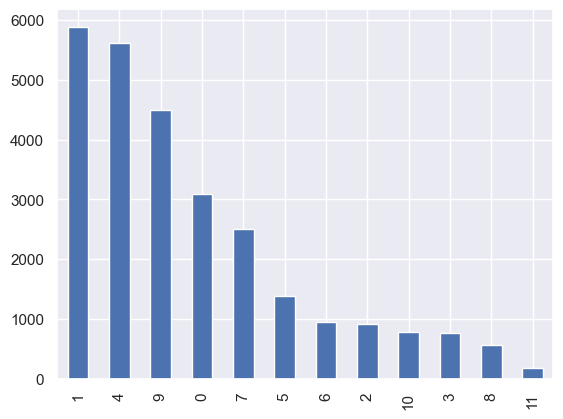

In [538]:
job.convert()
job.plot()

 #### ピボットテーブルによる集計

In [539]:
job.pivot('id')

job,0,1,2,3,4,5,6,7,8,9,10,11
y,,,,,,,,,,,,
0,2138,3796,567,549,3900,881,659,1676,468,3094,591,126
1,947,2090,347,216,1720,510,286,830,89,1397,199,52


 ### ダミー変数化

In [540]:
#job.dummy()
df = job.dummy()
df.head()

,id,age,marital,education,default,amount,housing,loan,contact,day,...,job_2,job_3,job_4,job_5,job_6,job_7,job_8,job_9,job_10,job_11
0,1,39,married,secondary,no,1756.0,yes,no,cellular,3,...,0,0,0,0,0,0,0,0,0,0
1,2,51,married,primary,no,1443.0,no,no,cellular,18,...,1,0,0,0,0,0,0,0,0,0
2,3,36,single,tertiary,no,436.0,no,no,cellular,13,...,0,0,1,0,0,0,0,0,0,0
3,4,63,married,secondary,no,474.0,no,no,cellular,25,...,0,0,0,1,0,0,0,0,0,0
4,5,31,single,tertiary,no,354.0,no,no,cellular,30,...,0,0,1,0,0,0,0,0,0,0


 ### 最終学歴カテゴリ確認

In [541]:
education = CategoricalData(df, 'education')

In [542]:
education.show()

secondary    13882
tertiary      7959
primary       4150
unknown       1137
Name: education, dtype: int64

<Axes: >

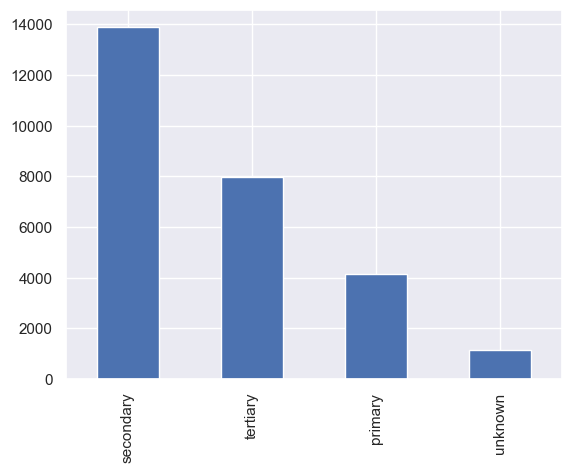

In [543]:
education.plot()

 #### カテゴリーデータを数値に変換

<Axes: >

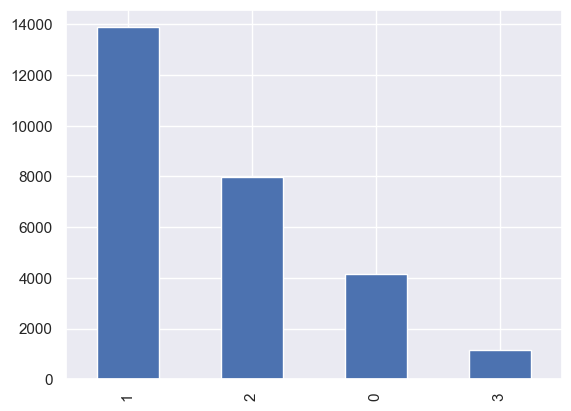

In [544]:
education.convert()
education.plot()

 #### ピボットテーブルによる集計

In [545]:
education.pivot('id')

education,0,1,2,3
y,,,,
0,2691,9445,5574,735
1,1459,4437,2385,402


 ### ダミー変数化

In [546]:
df = education.dummy()
df.head()

,id,age,marital,default,amount,housing,loan,contact,day,month,...,job_6,job_7,job_8,job_9,job_10,job_11,education_0,education_1,education_2,education_3
0,1,39,married,no,1756.0,yes,no,cellular,3,apr,...,0,0,0,0,0,0,0,1,0,0
1,2,51,married,no,1443.0,no,no,cellular,18,feb,...,0,0,0,0,0,0,1,0,0,0
2,3,36,single,no,436.0,no,no,cellular,13,apr,...,0,0,0,0,0,0,0,0,1,0
3,4,63,married,no,474.0,no,no,cellular,25,jan,...,0,0,0,0,0,0,0,1,0,0
4,5,31,single,no,354.0,no,no,cellular,30,apr,...,0,0,0,0,0,0,0,0,1,0


 ### 既婚／未婚／離別カテゴリ確認

In [547]:
marital = CategoricalData(df, 'marital')

In [548]:
marital.show()

married     16411
single       7662
divorced     3055
Name: marital, dtype: int64

<Axes: >

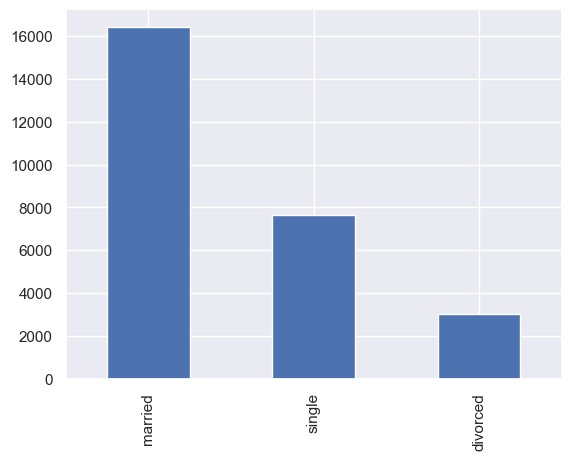

In [549]:
marital.plot()

 #### カテゴリーデータを数値に変換

<Axes: >

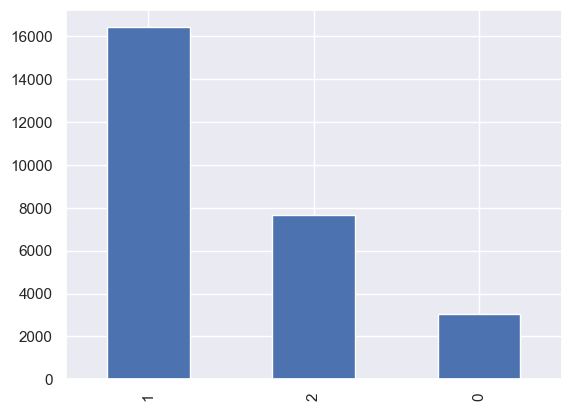

In [550]:
marital.convert()
marital.plot()

 #### ピボットテーブルによる集計

In [551]:
marital.pivot('id')

marital,0,1,2
y,,,
0,2033,10807,5605
1,1022,5604,2057


 ### ダミー変数化

In [552]:
df = marital.dummy()
df.head()

,id,age,default,amount,housing,loan,contact,day,month,duration,...,job_9,job_10,job_11,education_0,education_1,education_2,education_3,marital_0,marital_1,marital_2
0,1,39,no,1756.0,yes,no,cellular,3,apr,370.055237,...,0,0,0,0,1,0,0,0,1,0
1,2,51,no,1443.0,no,no,cellular,18,feb,233.998933,...,0,0,0,1,0,0,0,0,1,0
2,3,36,no,436.0,no,no,cellular,13,apr,NaN,...,0,0,0,0,0,1,0,0,0,1
3,4,63,no,474.0,no,no,cellular,25,jan,252.525808,...,0,0,0,0,1,0,0,0,1,0
4,5,31,no,354.0,no,no,cellular,30,apr,NaN,...,0,0,0,0,0,1,0,0,0,1


 ### 個人ローンの有無カテゴリ確認

In [553]:
loan = CategoricalData(df, 'loan')

In [554]:
loan.show()

no     22788
yes     4340
Name: loan, dtype: int64

<Axes: >

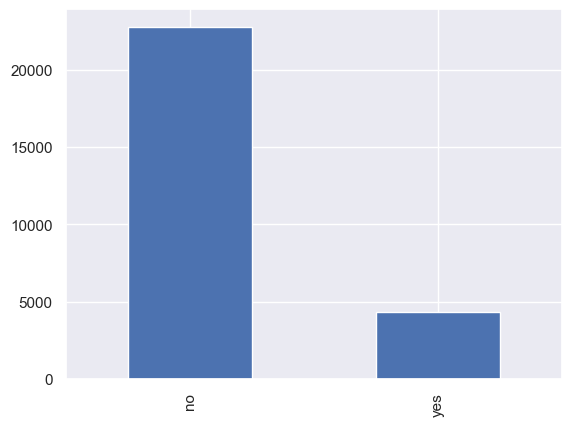

In [555]:
loan.plot()

 #### カテゴリーデータを数値に変換

<Axes: >

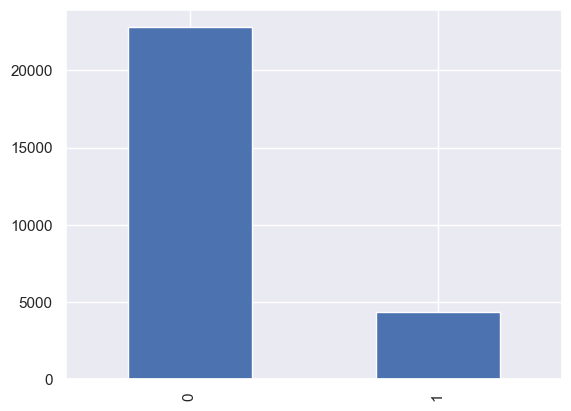

In [556]:
loan.convert()
loan.plot()

 #### ピボットテーブルによる集計

In [557]:
loan.pivot('id')

loan,0,1
y,,
0,15925,2520
1,6863,1820


 ### ダミー変数化

In [558]:
df = loan.dummy()
df.head()

,id,age,default,amount,housing,contact,day,month,duration,campaign,...,job_11,education_0,education_1,education_2,education_3,marital_0,marital_1,marital_2,loan_0,loan_1
0,1,39,no,1756.0,yes,cellular,3,apr,370.055237,1,...,0,0,1,0,0,0,1,0,1,0
1,2,51,no,1443.0,no,cellular,18,feb,233.998933,10,...,0,1,0,0,0,0,1,0,1,0
2,3,36,no,436.0,no,cellular,13,apr,NaN,1,...,0,0,0,1,0,0,0,1,1,0
3,4,63,no,474.0,no,cellular,25,jan,252.525808,1,...,0,0,1,0,0,0,1,0,1,0
4,5,31,no,354.0,no,cellular,30,apr,NaN,1,...,0,0,0,1,0,0,0,1,1,0


 ### 住宅ローンの有無カテゴリ確認

In [559]:
housing = CategoricalData(df, 'housing')

In [560]:
housing.show()

yes    15125
no     12003
Name: housing, dtype: int64

<Axes: >

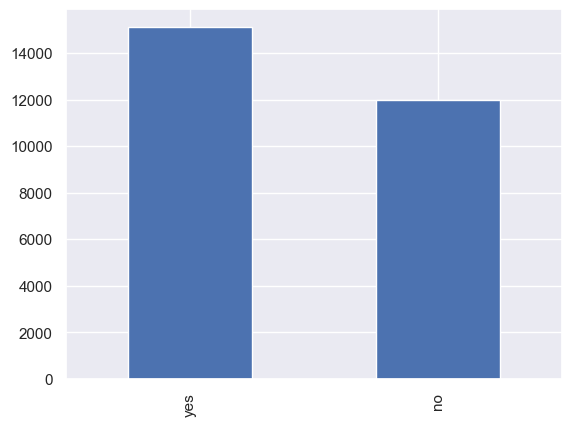

In [561]:
housing.plot()

 #### カテゴリーデータを数値に変換

<Axes: >

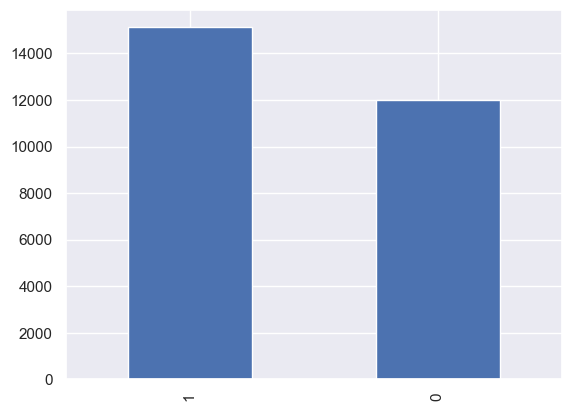

In [562]:
housing.convert()
housing.plot()

 #### ピボットテーブルによる集計

In [563]:
housing.pivot('id')

housing,0,1
y,,
0,9396,9049
1,2607,6076


 ### ダミー変数化

In [564]:
df = housing.dummy()
df.head()

,id,age,default,amount,contact,day,month,duration,campaign,previous,...,education_1,education_2,education_3,marital_0,marital_1,marital_2,loan_0,loan_1,housing_0,housing_1
0,1,39,no,1756.0,cellular,3,apr,370.055237,1,0,...,1,0,0,0,1,0,1,0,0,1
1,2,51,no,1443.0,cellular,18,feb,233.998933,10,0,...,0,0,0,0,1,0,1,0,1,0
2,3,36,no,436.0,cellular,13,apr,NaN,1,2,...,0,1,0,0,0,1,1,0,1,0
3,4,63,no,474.0,cellular,25,jan,252.525808,1,0,...,1,0,0,0,1,0,1,0,1,0
4,5,31,no,354.0,cellular,30,apr,NaN,1,2,...,0,1,0,0,0,1,1,0,1,0


 ### 債務不履行の有無カテゴリ確認

In [565]:
default = CategoricalData(df, 'default')

In [566]:
default.show()

no     26644
yes      484
Name: default, dtype: int64

<Axes: >

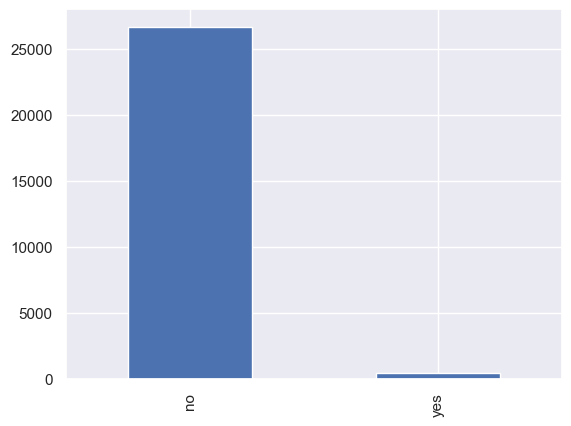

In [567]:
default.plot()

 #### カテゴリーデータを数値に変換

<Axes: >

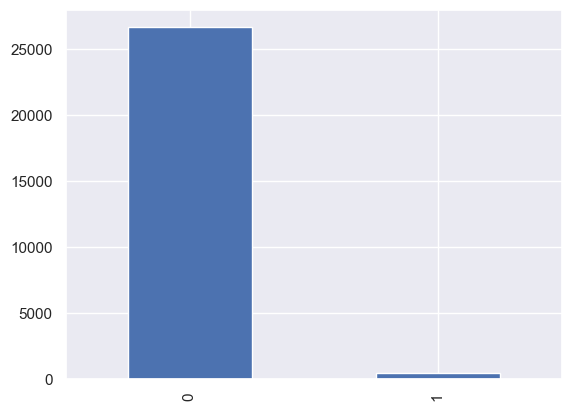

In [568]:
default.convert()
default.plot()

 #### ピボットテーブルによる集計

In [569]:
default.pivot('id')

default,0,1
y,,
0,18081,364
1,8563,120


 ### ダミー変数化

In [570]:
df = default.dummy()
df.head()

,id,age,amount,contact,day,month,duration,campaign,previous,y,...,education_3,marital_0,marital_1,marital_2,loan_0,loan_1,housing_0,housing_1,default_0,default_1
0,1,39,1756.0,cellular,3,apr,370.055237,1,0,1,...,0,0,1,0,1,0,0,1,1,0
1,2,51,1443.0,cellular,18,feb,233.998933,10,0,1,...,0,0,1,0,1,0,1,0,1,0
2,3,36,436.0,cellular,13,apr,NaN,1,2,0,...,0,0,0,1,1,0,1,0,1,0
3,4,63,474.0,cellular,25,jan,252.525808,1,0,0,...,0,0,1,0,1,0,1,0,1,0
4,5,31,354.0,cellular,30,apr,NaN,1,2,0,...,0,0,0,1,1,0,1,0,1,0


 ### 最終接触月確認

In [571]:
month = CategoricalData(df, 'month')

In [572]:
month.show()

may    8317
jul    4136
aug    3718
jun    3204
nov    2342
apr    1755
feb    1586
jan     846
oct     439
sep     356
mar     299
dec     130
Name: month, dtype: int64

<Axes: >

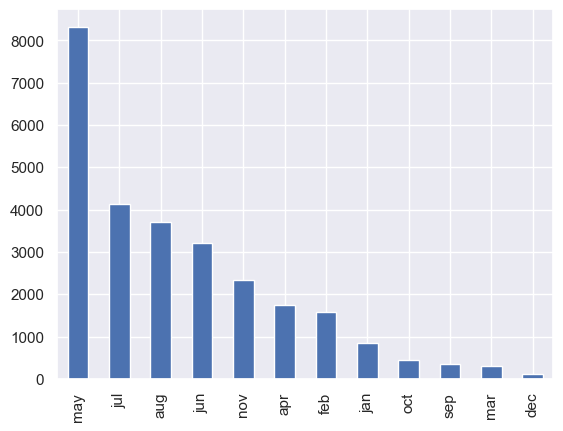

In [573]:
month.plot()

 #### カテゴリーデータを数値に変換

<Axes: >

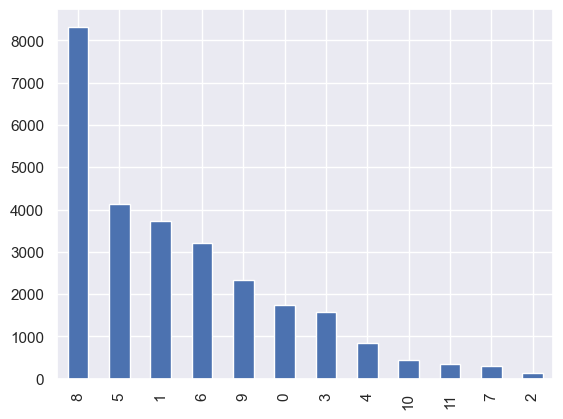

In [574]:
month.convert()
month.plot()

 #### ピボットテーブルによる集計

In [575]:
month.pivot('id')

month,0,1,2,3,4,5,6,7,8,9,10,11
y,,,,,,,,,,,,
0,1204,2788,86,1165,669,2869,2046,194,5079,1791,309,245
1,551,930,44,421,177,1267,1158,105,3238,551,130,111


 ### 連絡方法カテゴリ確認

In [576]:
contact = CategoricalData(df, 'contact')

In [577]:
contact.show()

cellular             17580
sending _document     7861
telephone             1687
Name: contact, dtype: int64

<Axes: >

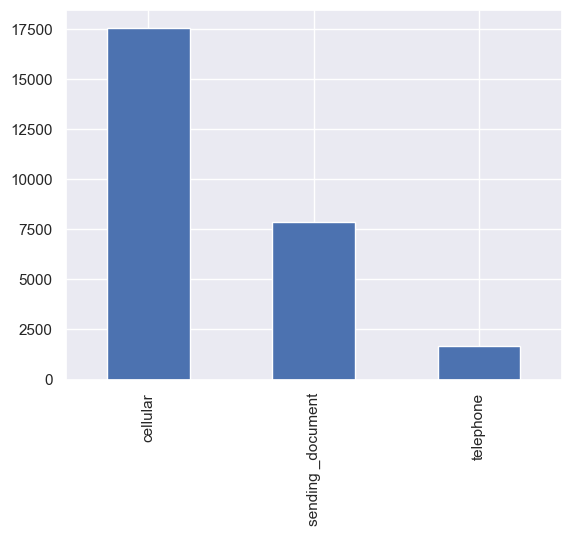

In [578]:
contact.plot()

 #### カテゴリーデータを数値に変換

<Axes: >

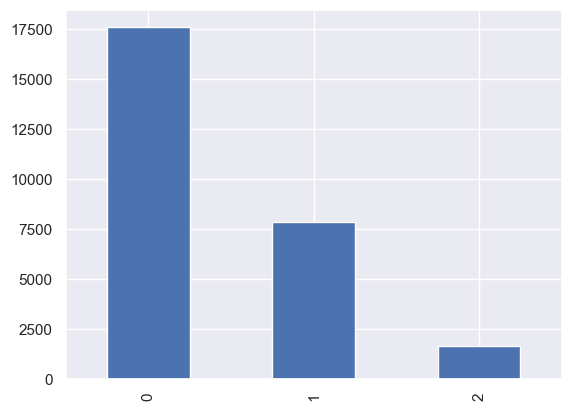

In [579]:
contact.convert()
contact.plot()

 #### ピボットテーブルによる集計

In [580]:
contact.pivot('id')

contact,0,1,2
y,,,
0,12712,4577,1156
1,4868,3284,531


 ### ダミー変数化

In [581]:
df = contact.dummy()
df.head()

,id,age,amount,day,month,duration,campaign,previous,y,job_0,...,marital_2,loan_0,loan_1,housing_0,housing_1,default_0,default_1,contact_0,contact_1,contact_2
0,1,39,1756.0,3,0,370.055237,1,0,1,0,...,0,1,0,0,1,1,0,1,0,0
1,2,51,1443.0,18,3,233.998933,10,0,1,0,...,0,1,0,1,0,1,0,1,0,0
2,3,36,436.0,13,0,NaN,1,2,0,0,...,1,1,0,1,0,1,0,1,0,0
3,4,63,474.0,25,4,252.525808,1,0,0,0,...,0,1,0,1,0,1,0,1,0,0
4,5,31,354.0,30,0,NaN,1,2,0,0,...,1,1,0,1,0,1,0,1,0,0


 ### データの目的変数確認

In [582]:
df['y'].value_counts()

0    18445
1     8683
Name: y, dtype: int64

<Axes: >

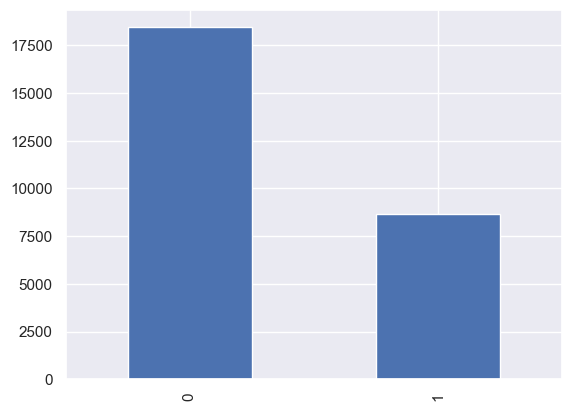

In [583]:
df['y'].value_counts().plot(kind='bar')

 ### データの可視化

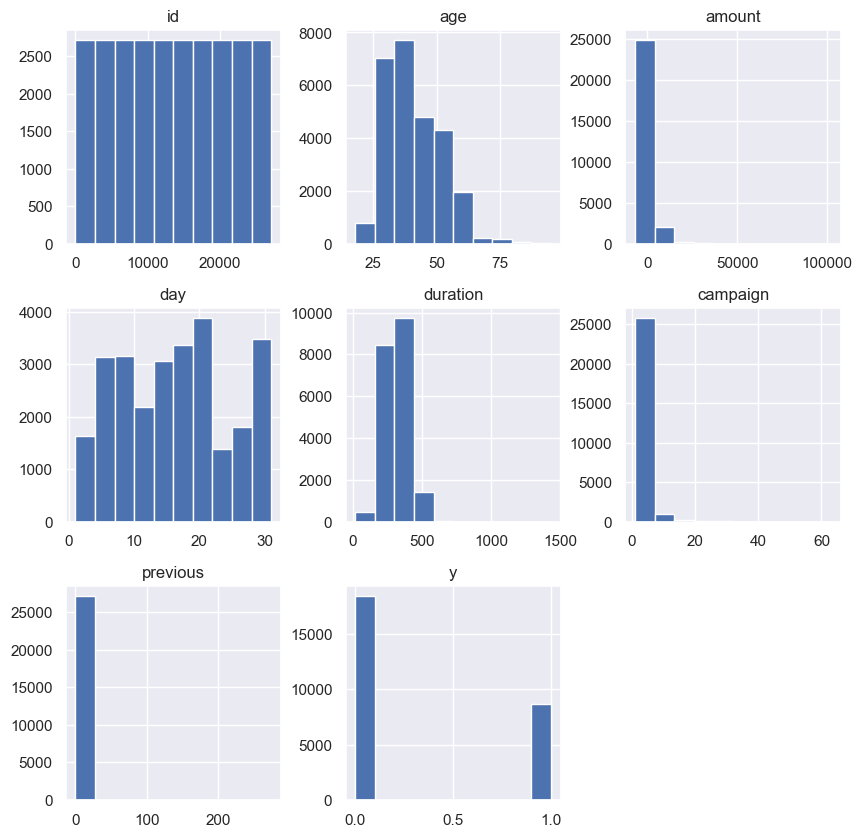

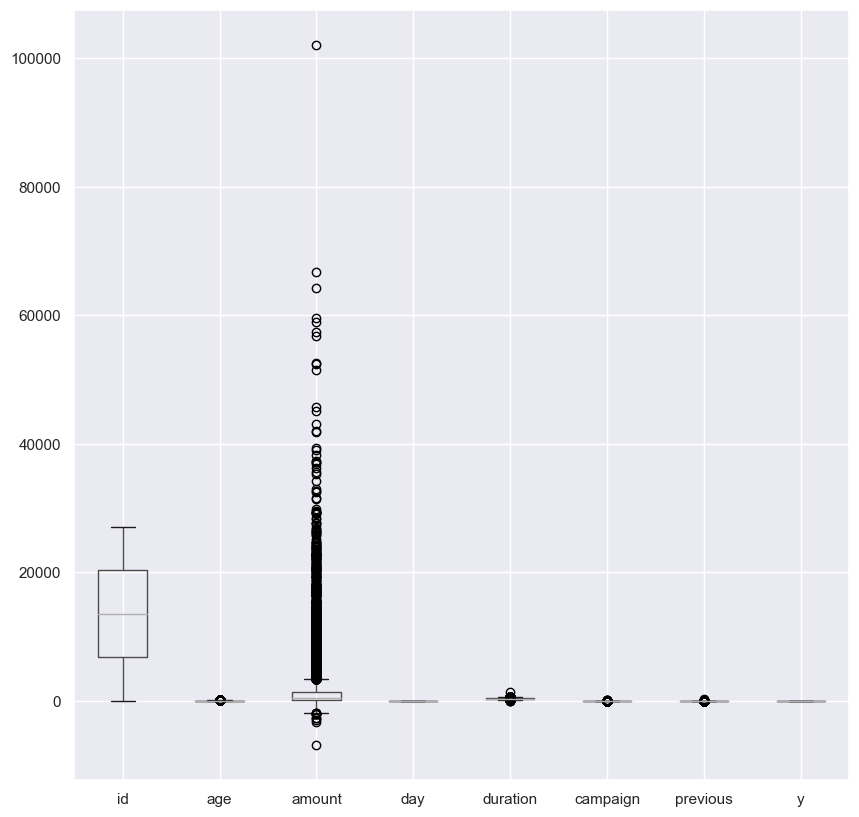

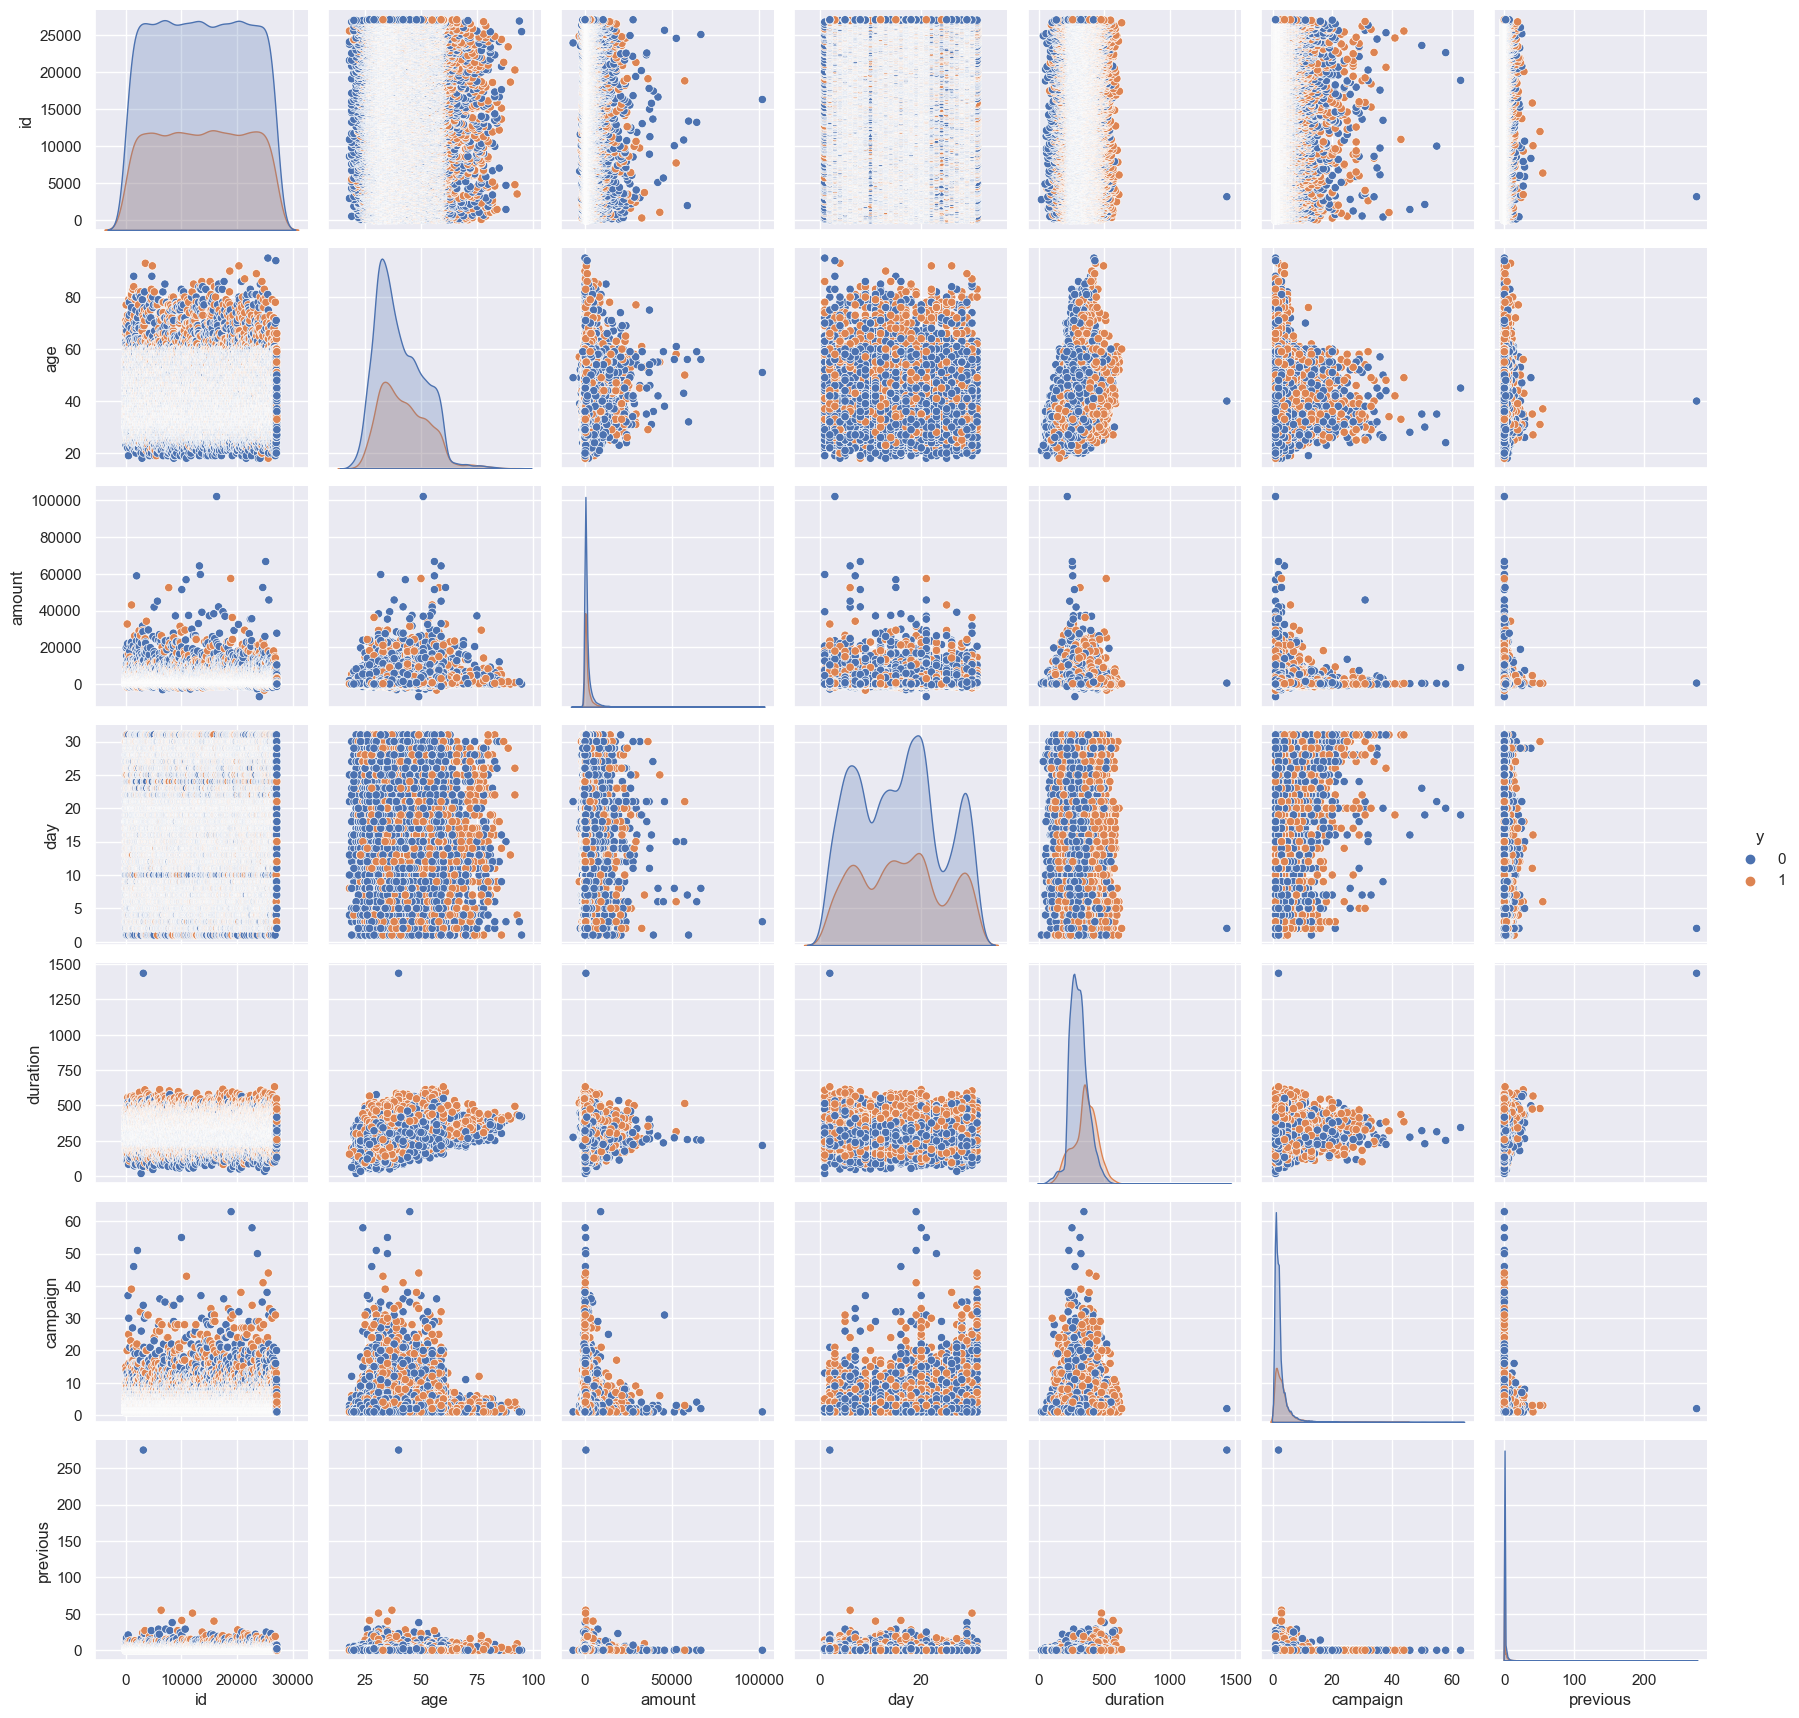

In [584]:
# %matplotlib inline
df = new_df()
exec_all = plot_df(df)
exec_all(plot_on)

 ### データの欠損確認

In [585]:
df.isnull().any()

id           False
age          False
job          False
marital      False
education    False
default      False
amount       False
housing      False
loan         False
contact      False
day          False
month        False
duration      True
campaign     False
previous     False
y            False
dtype: bool

In [586]:
df.isnull().sum()

id              0
age             0
job             0
marital         0
education       0
default         0
amount          0
housing         0
loan            0
contact         0
day             0
month           0
duration     7044
campaign        0
previous        0
y               0
dtype: int64

 ### データの重複確認

In [587]:
df.duplicated().sum()

0

 ## 分析の実施

 ## データの前処理

 ### CSVファイルの読み込み

In [588]:
import pandas as pd
df = new_df()
df.head()

,id,age,job,marital,education,default,amount,housing,loan,contact,day,month,duration,campaign,previous,y
0,1,39,blue-collar,married,secondary,no,1756.0,yes,no,cellular,3,apr,370.055237,1,0,1
1,2,51,entrepreneur,married,primary,no,1443.0,no,no,cellular,18,feb,233.998933,10,0,1
2,3,36,management,single,tertiary,no,436.0,no,no,cellular,13,apr,NaN,1,2,0
3,4,63,retired,married,secondary,no,474.0,no,no,cellular,25,jan,252.525808,1,0,0
4,5,31,management,single,tertiary,no,354.0,no,no,cellular,30,apr,NaN,1,2,0


 ### 欠損地処理（行削除・全体代表値埋め、グループ代表値埋め）

 ### 欠損値を含む行を削除

In [589]:
df.dropna(inplace=True)

 ### 各手法を必要に応じて実施

 - 外れ値の除外
 - 多項式特徴量・交互作用特徴量の追加
 - 特徴量の絞り込み
 - 標準化

 ### 特徴量xと正解tに分割

In [590]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import LabelEncoder

# カテゴリカル変数を指定してLabelEncoderを作成
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month']
for col in categorical_cols:
    CategoricalData(df, col).convert()

# データの分割とスケーリング
X = df.drop('y', axis=1)
y = df['y']

 ### 教師データの分割

In [591]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

 ## モデルの作成と学習

 ### 未学習状態モデルの生成（分類なら決定木、回帰なら線形回帰）

In [592]:
# model = tree.DecisionTreeClassifier(max_depth=3, random_state=1234)
check_learn(X_train_std, y_train)
treain_score, test_score, model = learn(X_train_std, y_train, depth=8)

深さ1:訓練データの正解率0.69:テストデータの正解率0.683
深さ2:訓練データの正解率0.661:テストデータの正解率0.652
深さ3:訓練データの正解率0.695:テストデータの正解率0.694
深さ4:訓練データの正解率0.709:テストデータの正解率0.712
深さ5:訓練データの正解率0.77:テストデータの正解率0.764
深さ6:訓練データの正解率0.788:テストデータの正解率0.78
深さ7:訓練データの正解率0.802:テストデータの正解率0.786
深さ8:訓練データの正解率0.817:テストデータの正解率0.783
深さ9:訓練データの正解率0.835:テストデータの正解率0.771
深さ10:訓練データの正解率0.854:テストデータの正解率0.766
深さ11:訓練データの正解率0.88:テストデータの正解率0.763
深さ12:訓練データの正解率0.902:テストデータの正解率0.754
深さ13:訓練データの正解率0.923:テストデータの正解率0.747
深さ14:訓練データの正解率0.946:テストデータの正解率0.743


 ### 訓練データで学習（必要に応じて不均衡データ補正）

In [593]:
model.fit(X_train_std, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=8, random_state=0)

 ## モデルの評価

In [594]:
model.score(X_test_std, y_test)

0.7993527508090615

In [595]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test_std)
accuracy_score(y_test, y_pred)

0.7993527508090615

 ### 検証データで評価し指標確認（分類なら正解率、回帰なら決定係数）

 ### 特徴量重要度をデータフレームに変換して表示

In [596]:
pd.DataFrame(model.feature_importances_, index=X.columns)

,0
id,0.008886
age,0.145131
job,0.004074
marital,0.001534
education,0.001308
default,0.000000
amount,0.012920
housing,0.094611
loan,0.062813
contact,0.012281


 ### 決定木における特徴量の考察

In [597]:
import numpy as np

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train_std.shape[1]):
    print(f'{f+1}番目に重要な特徴量：{X.columns[indices[f]]} {importances[indices[f]]}')

1番目に重要な特徴量：duration 0.4433895962589087
2番目に重要な特徴量：campaign 0.187721531432321
3番目に重要な特徴量：age 0.14513099809323624
4番目に重要な特徴量：housing 0.09461145180794735
5番目に重要な特徴量：loan 0.06281267984697401
6番目に重要な特徴量：month 0.01473882804128882
7番目に重要な特徴量：amount 0.012920028582195986
8番目に重要な特徴量：contact 0.012281174286635194
9番目に重要な特徴量：id 0.00888587445751927
10番目に重要な特徴量：day 0.006827904384379279
11番目に重要な特徴量：job 0.004073813929825153
12番目に重要な特徴量：previous 0.0037646412428874692
13番目に重要な特徴量：marital 0.0015335670302177098
14番目に重要な特徴量：education 0.001307910605663764
15番目に重要な特徴量：default 0.0


 ### NG:改善案検討前処理に戻る

 #### モデルの再学習

 ##### Take1
 - 接触時の平均時間、キャンペーン前に接触した回数、年齢、住宅ローンの有無を特徴量として学習する
 - 接触時の平均時間の欠損値は削除する
 - 住宅ローンの有無を数値化する

In [598]:
df = new_df()

df.dropna(inplace=True)
categorical_cols = ['housing']
for c in categorical_cols:
    CategoricalData(df, c).convert()

col = ['duration', 'campaign', 'age', 'housing']
x = df[col]
t = df['y']

check_learn(x, t)
treain_score, test_score, model = learn(x, t, depth=8)
take1 = model.score(x, t)
take1

深さ1:訓練データの正解率0.69:テストデータの正解率0.68
深さ2:訓練データの正解率0.663:テストデータの正解率0.652
深さ3:訓練データの正解率0.699:テストデータの正解率0.686
深さ4:訓練データの正解率0.732:テストデータの正解率0.723
深さ5:訓練データの正解率0.75:テストデータの正解率0.738
深さ6:訓練データの正解率0.742:テストデータの正解率0.732
深さ7:訓練データの正解率0.76:テストデータの正解率0.747
深さ8:訓練データの正解率0.771:テストデータの正解率0.744
深さ9:訓練データの正解率0.775:テストデータの正解率0.736
深さ10:訓練データの正解率0.789:テストデータの正解率0.738
深さ11:訓練データの正解率0.805:テストデータの正解率0.722
深さ12:訓練データの正解率0.821:テストデータの正解率0.728
深さ13:訓練データの正解率0.832:テストデータの正解率0.72
深さ14:訓練データの正解率0.851:テストデータの正解率0.713


0.7658832901812388

 ##### Take2
 - 接触時の平均時間、キャンペーン前に接触した回数、年齢、住宅ローンの有無を特徴量として学習する
 - 接触時の平均時間の欠損値は削除する
 - 住宅ローンの有無をダミー化する

In [599]:
df = new_df()

df.dropna(inplace=True)
housing = CategoricalData(df, 'housing')
df = housing.dummy()

col = ['duration', 'campaign', 'age', 'housing_yes', 'housing_no']
x = df[col]
t = df['y']

check_learn(x, t)
treain_score, test_score, model = learn(x, t, depth=8)
take2 = model.score(x, t)
take2

深さ1:訓練データの正解率0.69:テストデータの正解率0.68
深さ2:訓練データの正解率0.663:テストデータの正解率0.652
深さ3:訓練データの正解率0.699:テストデータの正解率0.686
深さ4:訓練データの正解率0.732:テストデータの正解率0.723
深さ5:訓練データの正解率0.75:テストデータの正解率0.738
深さ6:訓練データの正解率0.742:テストデータの正解率0.732
深さ7:訓練データの正解率0.76:テストデータの正解率0.747
深さ8:訓練データの正解率0.771:テストデータの正解率0.744
深さ9:訓練データの正解率0.775:テストデータの正解率0.737
深さ10:訓練データの正解率0.789:テストデータの正解率0.739
深さ11:訓練データの正解率0.805:テストデータの正解率0.722
深さ12:訓練データの正解率0.821:テストデータの正解率0.727
深さ13:訓練データの正解率0.832:テストデータの正解率0.722
深さ14:訓練データの正解率0.851:テストデータの正解率0.715


0.7658832901812388

 ##### Take3
 - 接触時の平均時間、キャンペーン前に接触した回数、年齢、住宅ローンの有無を特徴量として学習する
 - 接触時の平均時間の欠損値は平均時間で埋める
 - 住宅ローンの有無を数値化する

In [600]:
df = new_df()

df['duration'].fillna(df['duration'].mean(), inplace=True)
categorical_cols = ['housing']
for c in categorical_cols:
    CategoricalData(df, c).convert()


col = ['duration', 'campaign', 'age', 'housing']
x = df[col]
t = df['y']

depth = 20
check_learn(x, t, depth)
treain_score, test_score, model = learn(x, t, 7)
take3 = model.score(x, t)
take3

深さ1:訓練データの正解率0.716:テストデータの正解率0.698
深さ2:訓練データの正解率0.663:テストデータの正解率0.663
深さ3:訓練データの正解率0.657:テストデータの正解率0.656
深さ4:訓練データの正解率0.737:テストデータの正解率0.734
深さ5:訓練データの正解率0.768:テストデータの正解率0.764
深さ6:訓練データの正解率0.797:テストデータの正解率0.785
深さ7:訓練データの正解率0.82:テストデータの正解率0.805
深さ8:訓練データの正解率0.819:テストデータの正解率0.799
深さ9:訓練データの正解率0.827:テストデータの正解率0.8
深さ10:訓練データの正解率0.836:テストデータの正解率0.794
深さ11:訓練データの正解率0.844:テストデータの正解率0.791
深さ12:訓練データの正解率0.86:テストデータの正解率0.792
深さ13:訓練データの正解率0.869:テストデータの正解率0.785
深さ14:訓練データの正解率0.885:テストデータの正解率0.781
深さ15:訓練データの正解率0.896:テストデータの正解率0.776
深さ16:訓練データの正解率0.907:テストデータの正解率0.772
深さ17:訓練データの正解率0.921:テストデータの正解率0.77
深さ18:訓練データの正解率0.931:テストデータの正解率0.769
深さ19:訓練データの正解率0.944:テストデータの正解率0.772
深さ20:訓練データの正解率0.953:テストデータの正解率0.768


0.8171630787378354

 ##### Take4
 - 接触時の平均時間を特徴量として学習する
 - 接触時の平均時間の欠損値は平均時間で埋める
 - 住宅ローンの有無を数値化する

In [601]:
df = new_df()

df['duration'].fillna(df['duration'].mean(), inplace=True)
categorical_cols = ['housing']
for c in categorical_cols:
    CategoricalData(df, c).convert()


col = ['duration']
x = df[col]
t = df['y']

check_learn(x, t)
treain_score, test_score, model = learn(x, t, 9)
take4 = model.score(x, t)
take4

深さ1:訓練データの正解率0.716:テストデータの正解率0.698
深さ2:訓練データの正解率0.721:テストデータの正解率0.705
深さ3:訓練データの正解率0.712:テストデータの正解率0.7
深さ4:訓練データの正解率0.712:テストデータの正解率0.696
深さ5:訓練データの正解率0.713:テストデータの正解率0.697
深さ6:訓練データの正解率0.714:テストデータの正解率0.697
深さ7:訓練データの正解率0.714:テストデータの正解率0.694
深さ8:訓練データの正解率0.719:テストデータの正解率0.696
深さ9:訓練データの正解率0.719:テストデータの正解率0.696
深さ10:訓練データの正解率0.725:テストデータの正解率0.694
深さ11:訓練データの正解率0.727:テストデータの正解率0.691
深さ12:訓練データの正解率0.736:テストデータの正解率0.69
深さ13:訓練データの正解率0.743:テストデータの正解率0.689
深さ14:訓練データの正解率0.749:テストデータの正解率0.687


0.7147965202005309

 ##### Take5
 - 接触時の平均時間、キャンペーン前に接触した回数、年齢、住宅ローンの有無を特徴量として学習する
 - 接触時の平均時間の欠損値は削除する
 - 接触時の平均時間の外れ値を削除する
 - 住宅ローンの有無を数値化する

In [602]:
df = new_df()

df.dropna(inplace=True)
no = df[(df['duration'] > 1400)].index
df = df.drop(no, axis=0)
categorical_cols = ['housing']
for c in categorical_cols:
    CategoricalData(df, c).convert()

col = ['duration', 'campaign', 'age', 'housing']
x = df[col]
t = df['y']

check_learn(x, t)
treain_score, test_score, model = learn(x, t, depth=8)
take5 = model.score(x, t)
take5

深さ1:訓練データの正解率0.67:テストデータの正解率0.667
深さ2:訓練データの正解率0.641:テストデータの正解率0.642
深さ3:訓練データの正解率0.73:テストデータの正解率0.715
深さ4:訓練データの正解率0.732:テストデータの正解率0.725
深さ5:訓練データの正解率0.751:テストデータの正解率0.735
深さ6:訓練データの正解率0.759:テストデータの正解率0.741
深さ7:訓練データの正解率0.754:テストデータの正解率0.732
深さ8:訓練データの正解率0.769:テストデータの正解率0.739
深さ9:訓練データの正解率0.778:テストデータの正解率0.735
深さ10:訓練データの正解率0.791:テストデータの正解率0.734
深さ11:訓練データの正解率0.803:テストデータの正解率0.724
深さ12:訓練データの正解率0.821:テストデータの正解率0.727
深さ13:訓練データの正解率0.839:テストデータの正解率0.717
深さ14:訓練データの正解率0.857:テストデータの正解率0.711


0.7633321714883234

 ##### Take6
 - 接触時の平均時間、キャンペーン前に接触した回数、年齢、住宅ローンの有無を特徴量として学習する
 - 接触時の平均時間の欠損値は平均時間で埋める
 - 接触時の平均時間の外れ値を削除する
 - 住宅ローンの有無を数値化する

In [603]:
df = new_df()

df['duration'].fillna(df['duration'].mean(), inplace=True)
no = df[(df['duration'] > 1400)].index
df = df.drop(no, axis=0)
categorical_cols = ['housing']
for c in categorical_cols:
    CategoricalData(df, c).convert()


col = ['duration', 'campaign', 'age', 'housing']
x = df[col]
t = df['y']

depth = 20
check_learn(x, t, depth)
treain_score, test_score, model = learn(x, t, 7)
take6 = model.score(x, t)
take6

深さ1:訓練データの正解率0.7:テストデータの正解率0.694
深さ2:訓練データの正解率0.649:テストデータの正解率0.647
深さ3:訓練データの正解率0.643:テストデータの正解率0.642
深さ4:訓練データの正解率0.737:テストデータの正解率0.74
深さ5:訓練データの正解率0.785:テストデータの正解率0.778
深さ6:訓練データの正解率0.797:テストデータの正解率0.792
深さ7:訓練データの正解率0.809:テストデータの正解率0.802
深さ8:訓練データの正解率0.814:テストデータの正解率0.8
深さ9:訓練データの正解率0.817:テストデータの正解率0.79
深さ10:訓練データの正解率0.828:テストデータの正解率0.792
深さ11:訓練データの正解率0.843:テストデータの正解率0.8
深さ12:訓練データの正解率0.854:テストデータの正解率0.79
深さ13:訓練データの正解率0.863:テストデータの正解率0.783
深さ14:訓練データの正解率0.88:テストデータの正解率0.78
深さ15:訓練データの正解率0.895:テストデータの正解率0.776
深さ16:訓練データの正解率0.909:テストデータの正解率0.771
深さ17:訓練データの正解率0.921:テストデータの正解率0.768
深さ18:訓練データの正解率0.932:テストデータの正解率0.767
深さ19:訓練データの正解率0.946:テストデータの正解率0.761
深さ20:訓練データの正解率0.954:テストデータの正解率0.762


0.8076086555829984

In [604]:
# 結果を比較
for i, take in enumerate([take1,take2, take3, take4, take5, take6]):
    print(f'take{i+1}:{take}')

take1:0.7658832901812388
take2:0.7658832901812388
take3:0.8171630787378354
take4:0.7147965202005309
take5:0.7633321714883234
take6:0.8076086555829984


 ### OK:最終性能評価（テストデータで評価）

 ##### Take3
 - 接触時の平均時間、キャンペーン前に接触した回数、年齢、住宅ローンの有無を特徴量として学習する
 - 接触時の平均時間の欠損値は平均時間で埋める
 - 住宅ローンの有無を数値化する

In [605]:
df = new_df()

df['duration'].fillna(df['duration'].mean(), inplace=True)
categorical_cols = ['housing']
for c in categorical_cols:
    CategoricalData(df, c).convert()


col = ['duration', 'campaign', 'age', 'housing']
x = df[col]
t = df['y']

check_learn(x, t)
treain_score, test_score, model = learn(x, t, 7)

model.score(x, t)

深さ1:訓練データの正解率0.716:テストデータの正解率0.698
深さ2:訓練データの正解率0.663:テストデータの正解率0.663
深さ3:訓練データの正解率0.657:テストデータの正解率0.656
深さ4:訓練データの正解率0.737:テストデータの正解率0.734
深さ5:訓練データの正解率0.768:テストデータの正解率0.764
深さ6:訓練データの正解率0.797:テストデータの正解率0.785
深さ7:訓練データの正解率0.82:テストデータの正解率0.805
深さ8:訓練データの正解率0.819:テストデータの正解率0.799
深さ9:訓練データの正解率0.827:テストデータの正解率0.8
深さ10:訓練データの正解率0.836:テストデータの正解率0.794
深さ11:訓練データの正解率0.844:テストデータの正解率0.791
深さ12:訓練データの正解率0.86:テストデータの正解率0.792
深さ13:訓練データの正解率0.869:テストデータの正解率0.785
深さ14:訓練データの正解率0.885:テストデータの正解率0.781


0.8171630787378354

 ### データの可視化

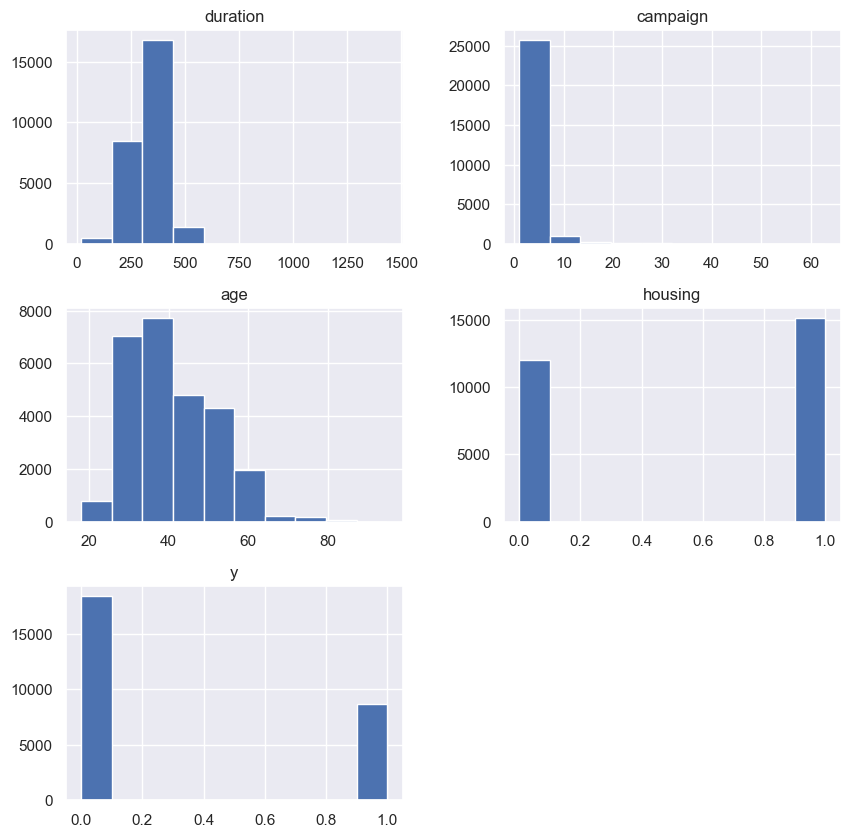

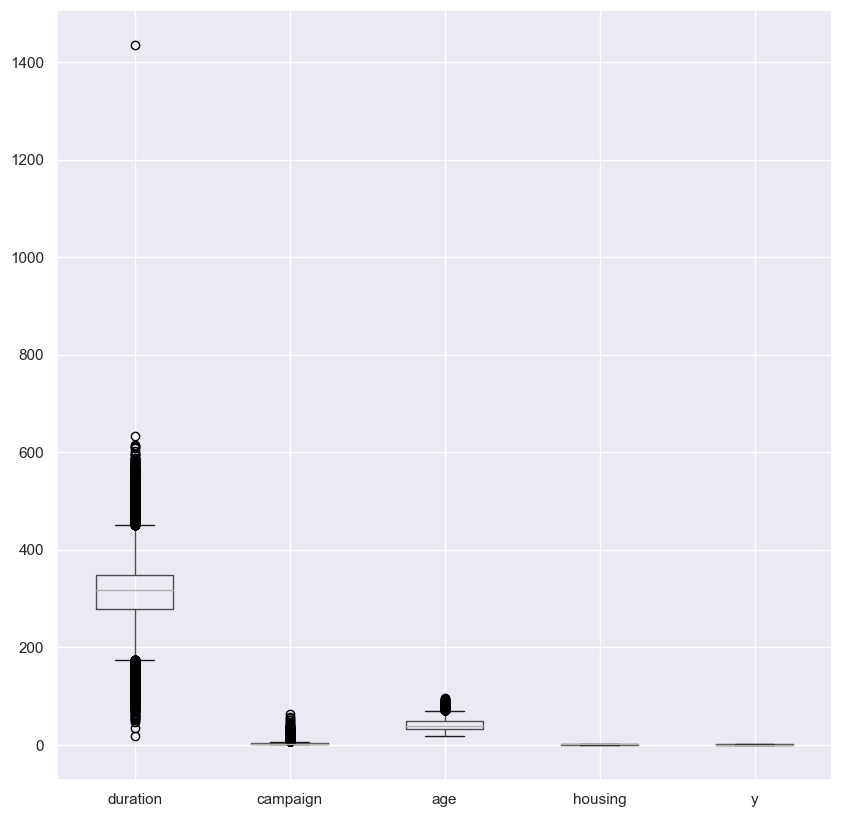

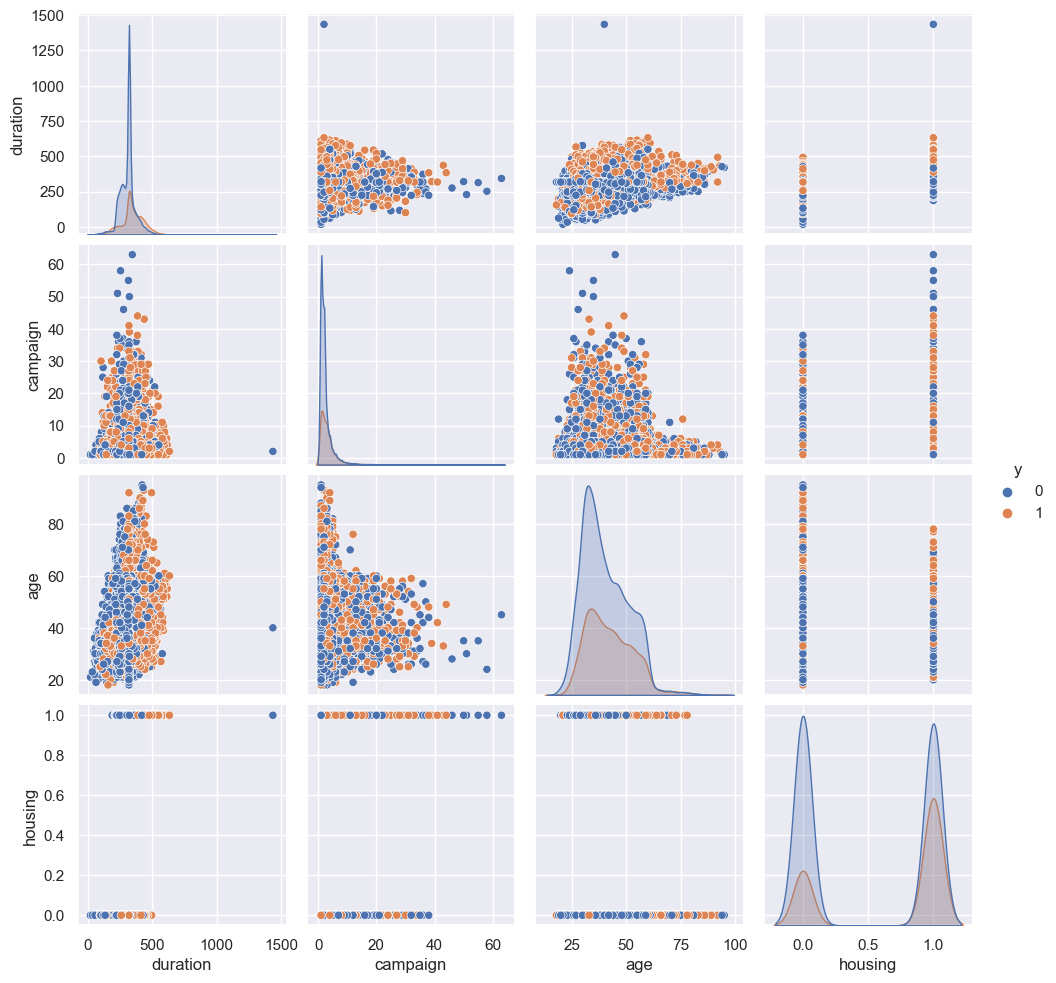

In [606]:
# %matplotlib inline
x_tmp = pd.concat([x, t], axis=1)
exec_all = plot_df(x_tmp)
exec_all(plot_on)

[Text(0.5, 0.875, 'duration <= 337.926\ngini = 0.5\nsamples = 21702\nvalue = [10851.0, 10851.0]'),
 Text(0.25, 0.625, 'campaign <= 2.5\ngini = 0.471\nsamples = 15554\nvalue = [8873.55, 5439.592]'),
 Text(0.125, 0.375, 'duration <= 213.423\ngini = 0.389\nsamples = 10475\nvalue = [6583.175, 2369.057]'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'duration <= 213.63\ngini = 0.489\nsamples = 5079\nvalue = [2290.375, 3070.535]'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'campaign <= 2.5\ngini = 0.392\nsamples = 6148\nvalue = [1977.45, 5411.408]'),
 Text(0.625, 0.375, 'duration <= 411.545\ngini = 0.451\nsamples = 4016\nvalue = [1556.544, 2970.324]'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'duration <= 397.583\ngini = 0.251\nsamples = 2132\nvalue = [420.906, 2441.084]'),
 Text(0.8125, 0.125, '\n  (...)  \n'),
 Text(0.9375, 0.

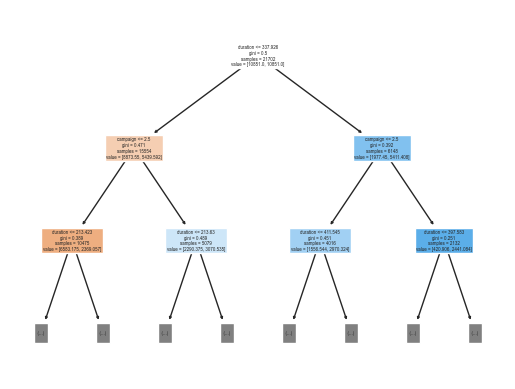

In [607]:
# %matplotlib inline
plot_tree(model, feature_names=x.columns, filled=True, max_depth=2)

 ### 学習したモデルを保存する

In [608]:
import pickle
file = path + '/model/campaign.pkl'
with open(file, 'wb') as f:
    pickle.dump(model, f)

In [609]:
doctest.testmod(verbose=True)
unittest.main(argv=[''], verbosity=2, exit=False)

15 items had no tests:
    __main__
    __main__.CategoricalData
    __main__.CategoricalData.__init__
    __main__.CategoricalData.convert
    __main__.CategoricalData.dummy
    __main__.CategoricalData.pivot
    __main__.CategoricalData.plot
    __main__.CategoricalData.show
    __main__.__VSCODE_compute_hash
    __main__.__VSCODE_wrap_run_cell
    __main__.check_learn
    __main__.exec_all
    __main__.learn
    __main__.new_df
    __main__.plot_df
0 tests in 15 items.
0 passed and 0 failed.
Test passed.



----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK
